<a href="https://colab.research.google.com/github/maxwillzq/algoTrading/blob/main/Portfolio_Optimization_Algo_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization and Algorithmic Trading

In [ ]:
! pip install pandas_datareader

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import logging
import numpy as np
%matplotlib inline
logger = logging.getLogger(__name__)

## Helper functions

In [ ]:
def read_stock_data_to_df(stock_name, start = None, end = None):
  #Read Stock Data from Yahoo Finance
  if end is None:
    end = dt.datetime.now()
  logger.info(f"today is {end}")
  if not start:
    start = dt.datetime(end.year-2, end.month, end.day)
  df = web.DataReader(stock_name, 'yahoo', start, end)
  df.to_csv(stock_name + '.csv')
  df = pd.read_csv(stock_name + '.csv')
  return df

def draw_regular_plot(df, stock_name=None):
  top = plt.subplot2grid((12,9), (0, 0), rowspan=10, colspan=9)
  bottom = plt.subplot2grid((12,9), (10,0), rowspan=2, colspan=9)
  top.plot(df.index, df['Adj Close'], color='blue') #df.index gives the dates
  bottom.bar(df.index, df['Volume'])
  # set the labels
  top.axes.get_xaxis().set_visible(False)
  if stock_name:
    top.set_title(stock_name)
  top.set_ylabel('Adj Close')
  bottom.set_ylabel('Volume')

def draw_density_plot(df, param = {}):
  plt.figure(figsize=(12,9))
  ax = sns.distplot(df['Adj Close'].dropna(), bins=50, color='purple', vertical=True)
  rmin = min(df['Adj Close']) * 0.9
  rmax = max(df['Adj Close']) * 1.1
  step = param.get("step", 5)
  plt.yticks(np.arange(rmin, rmax, step))

def draw_moving_average_plot(df, param={}):
  # simple moving averages
  lists = [20, 50, 200]
  if "list" in param:
    lists = param["list"]
  args = {}
  for item in lists:
    df['MA' + str(item)] = df['Adj Close'].rolling(item).mean()
    args['MA' + str(item)] = df['MA' + str(item)]
  args['Adj Close'] = df['Adj Close']
  df2 = pd.DataFrame(args)
  df2.plot(figsize=(12, 9), legend=True, title=stock_name)
  #df2.to_csv('AAPL_MA.csv')
  fig = plt.gcf()
  fig.set_size_inches(12, 9)
  #fig.savefig('AAPL_plot.png', dpi=300)
  plt.show()
  print(df.tail())


## Stock data trend review

In [ ]:
stock_name = "MSFT"
end = dt.datetime.now()
start = dt.datetime(end.year - 3, end.month, end.day)
df = read_stock_data_to_df(stock_name, start=start, end=end)
print(df.describe())

             High         Low        Open       Close        Volume   Adj Close
count  756.000000  756.000000  756.000000  756.000000  7.560000e+02  756.000000
mean   144.779220  141.666270  143.278426  143.298466  3.134199e+07  141.201408
std     42.689934   41.614847   42.141767   42.172992  1.423676e+07   43.168790
min     88.930000   83.830002   86.300003   85.010002  8.989200e+06   81.482643
25%    108.079998  105.627502  107.072502  106.930002  2.241270e+07  104.049625
50%    136.945000  134.985001  136.375000  136.059998  2.756150e+07  134.105354
75%    181.015003  176.367496  179.625000  179.787498  3.554178e+07  178.068611
max    232.860001  227.350006  229.270004  231.649994  1.112421e+08  231.045105


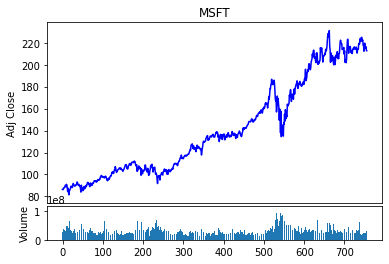

In [ ]:
draw_regular_plot(df, stock_name)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


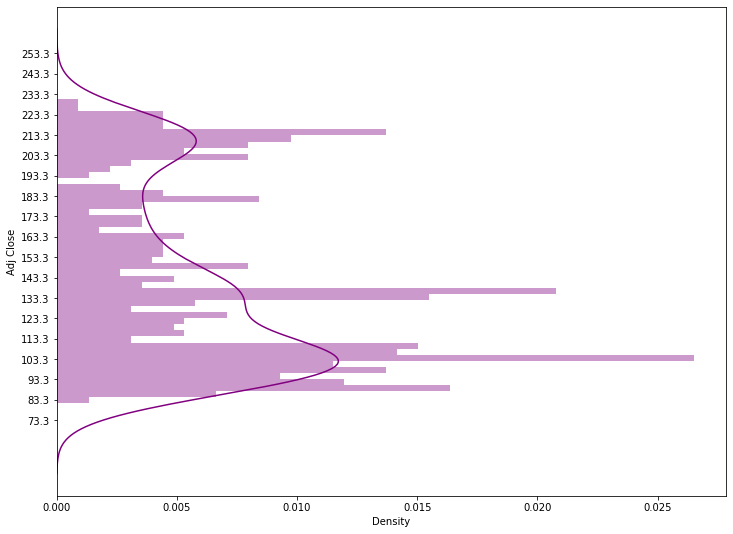

In [ ]:
param = {}
param["step"] = 10
draw_density_plot(df, param)

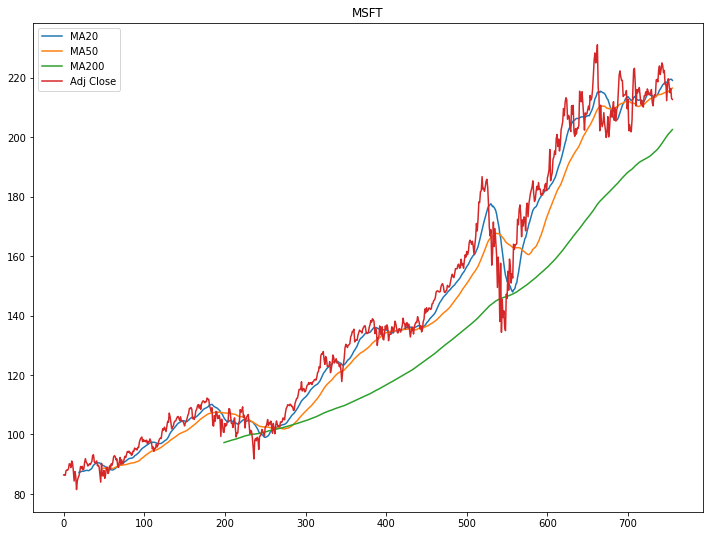

           Date        High         Low  ...        MA20        MA50       MA200
751  2021-01-11  218.910004  216.729996  ...  219.281499  215.611904  201.310884
752  2021-01-12  217.100006  213.320007  ...  219.364999  215.826795  201.642857
753  2021-01-13  216.759995  213.929993  ...  219.471999  216.114769  201.929640
754  2021-01-14  217.460007  212.740005  ...  219.416499  216.339135  202.212325
755  2021-01-15  214.509995  212.029999  ...  219.084998  216.474316  202.520941

[5 rows x 10 columns]


In [ ]:
draw_moving_average_plot(df)

In [ ]:
! pip install quandl

In [ ]:
#! pip install quandl
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
#GET YOUR QUANDL API KEY from https://www.quandl.com/account/profile
quandl.ApiConfig.api_key = 'dA7mtrRmEAxGHzVZFxy9' #'YOUR_QUANDL_API_KEY' 
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)
data.to_csv('stocks_data.csv')
print(data.head())
print(data.tail())

           date ticker  adj_close
None                             
0    2017-12-29  GOOGL    1053.40
1    2017-12-28  GOOGL    1055.95
2    2017-12-27  GOOGL    1060.20
3    2017-12-26  GOOGL    1065.85
4    2017-12-22  GOOGL    1068.86
           date ticker   adj_close
None                              
2001 2016-01-08   AAPL   93.677776
2002 2016-01-07   AAPL   93.185040
2003 2016-01-06   AAPL   97.291172
2004 2016-01-05   AAPL   99.233131
2005 2016-01-04   AAPL  101.783763


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 3 columns):
date         2006 non-null datetime64[ns]
ticker       2006 non-null object
adj_close    2006 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 47.1+ KB


In [ ]:
df = data.set_index('date')
table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,AAPL,AMZN,FB,GOOGL
date,,,,
2016-01-04,101.783763,636.99,102.22,759.44
2016-01-05,99.233131,633.79,102.73,761.53
2016-01-06,97.291172,632.65,102.97,759.33
2016-01-07,93.185040,607.94,97.92,741.00
2016-01-08,93.677776,607.05,97.33,730.91


Text(0,0.5,'price in $')

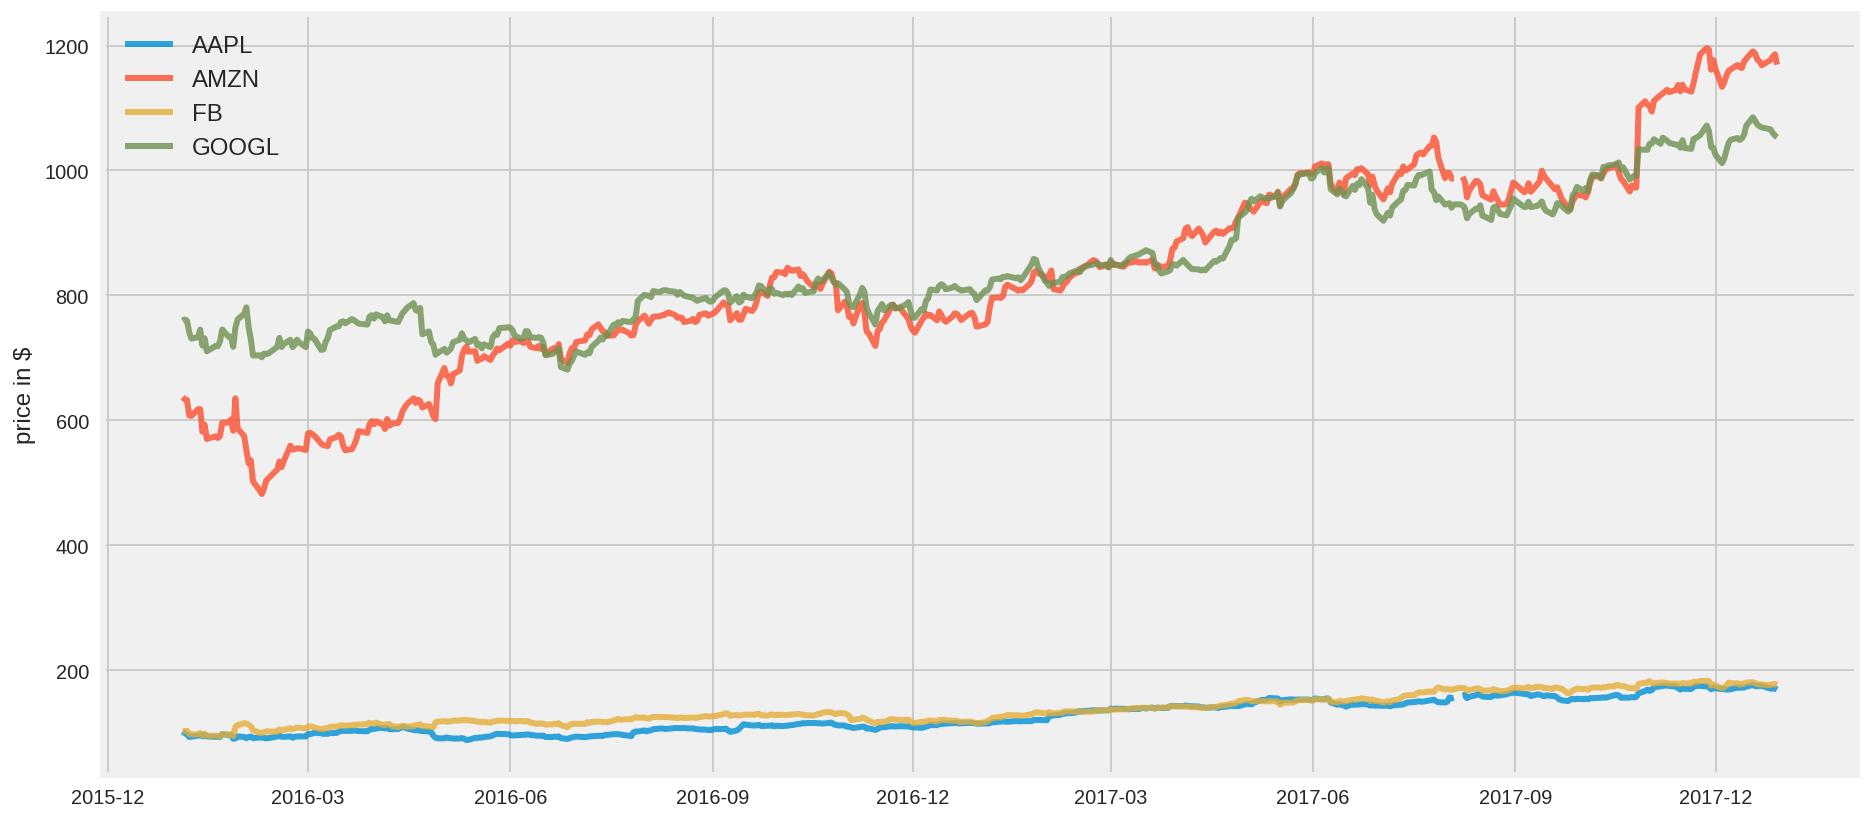

In [ ]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0,0.5,'daily returns')

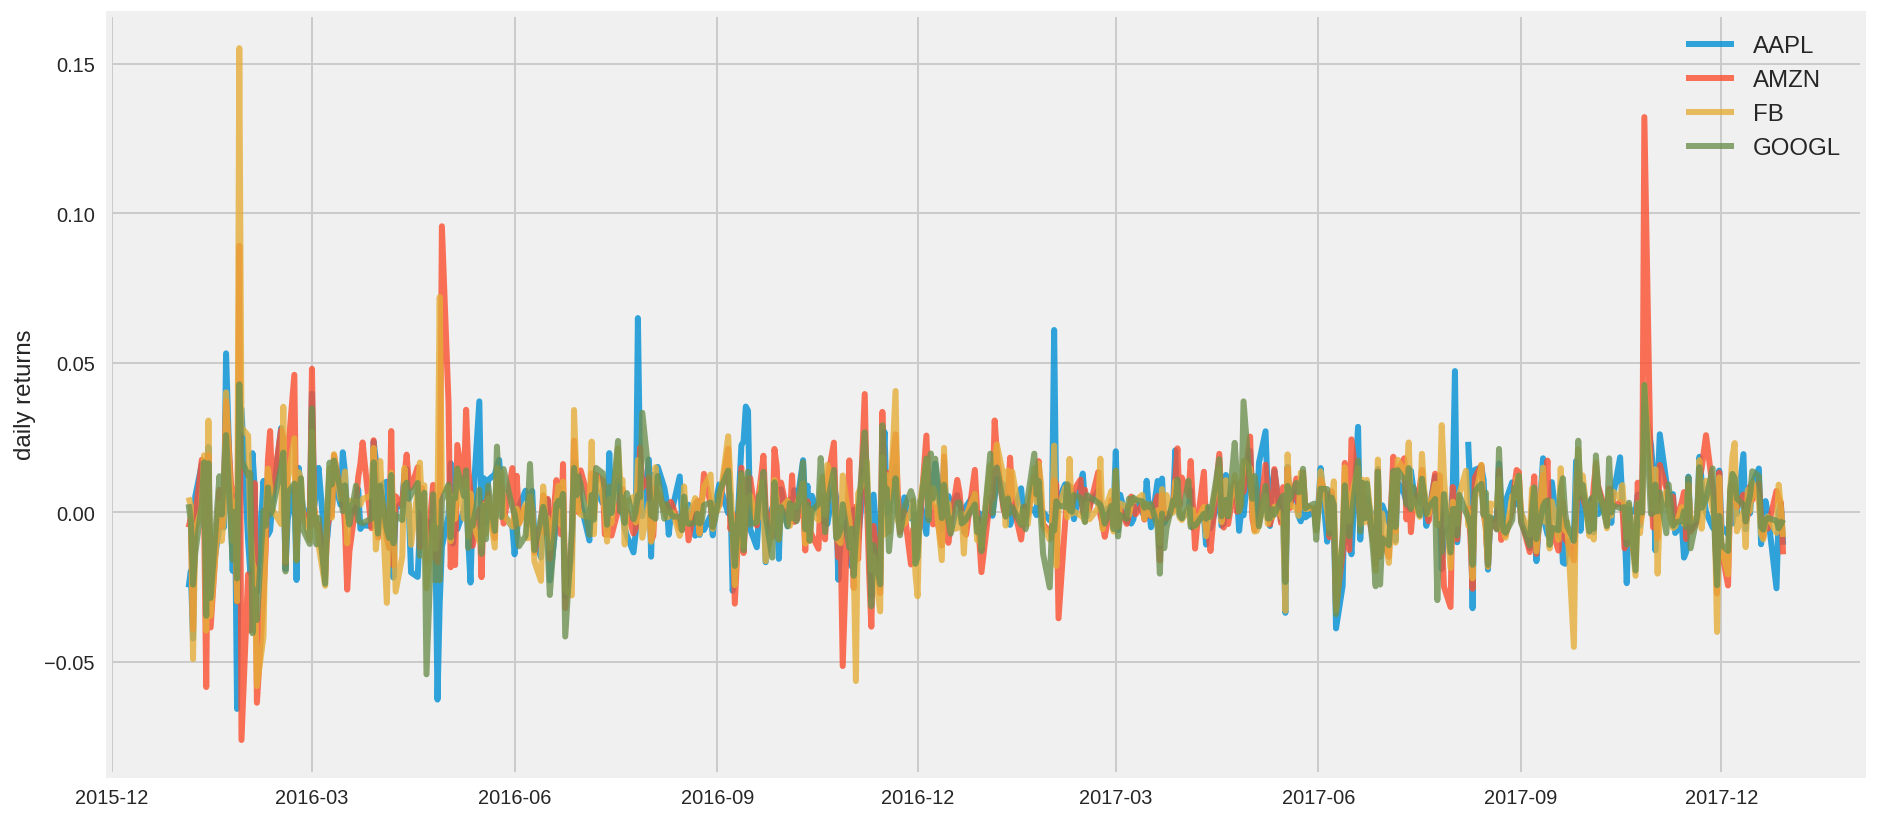

In [ ]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


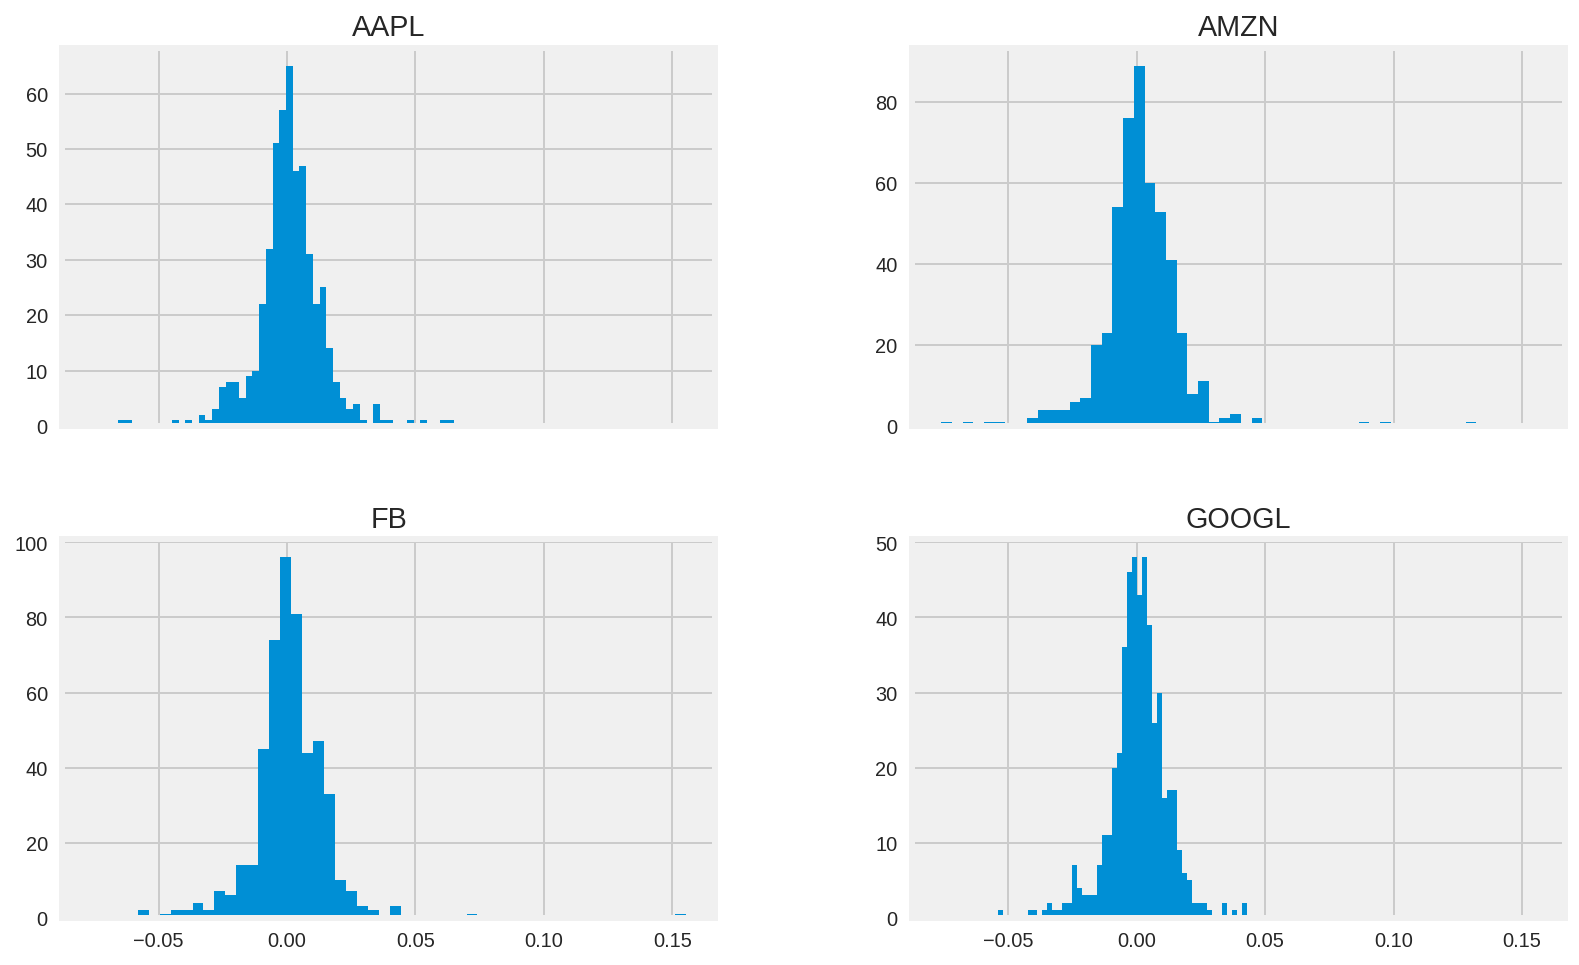

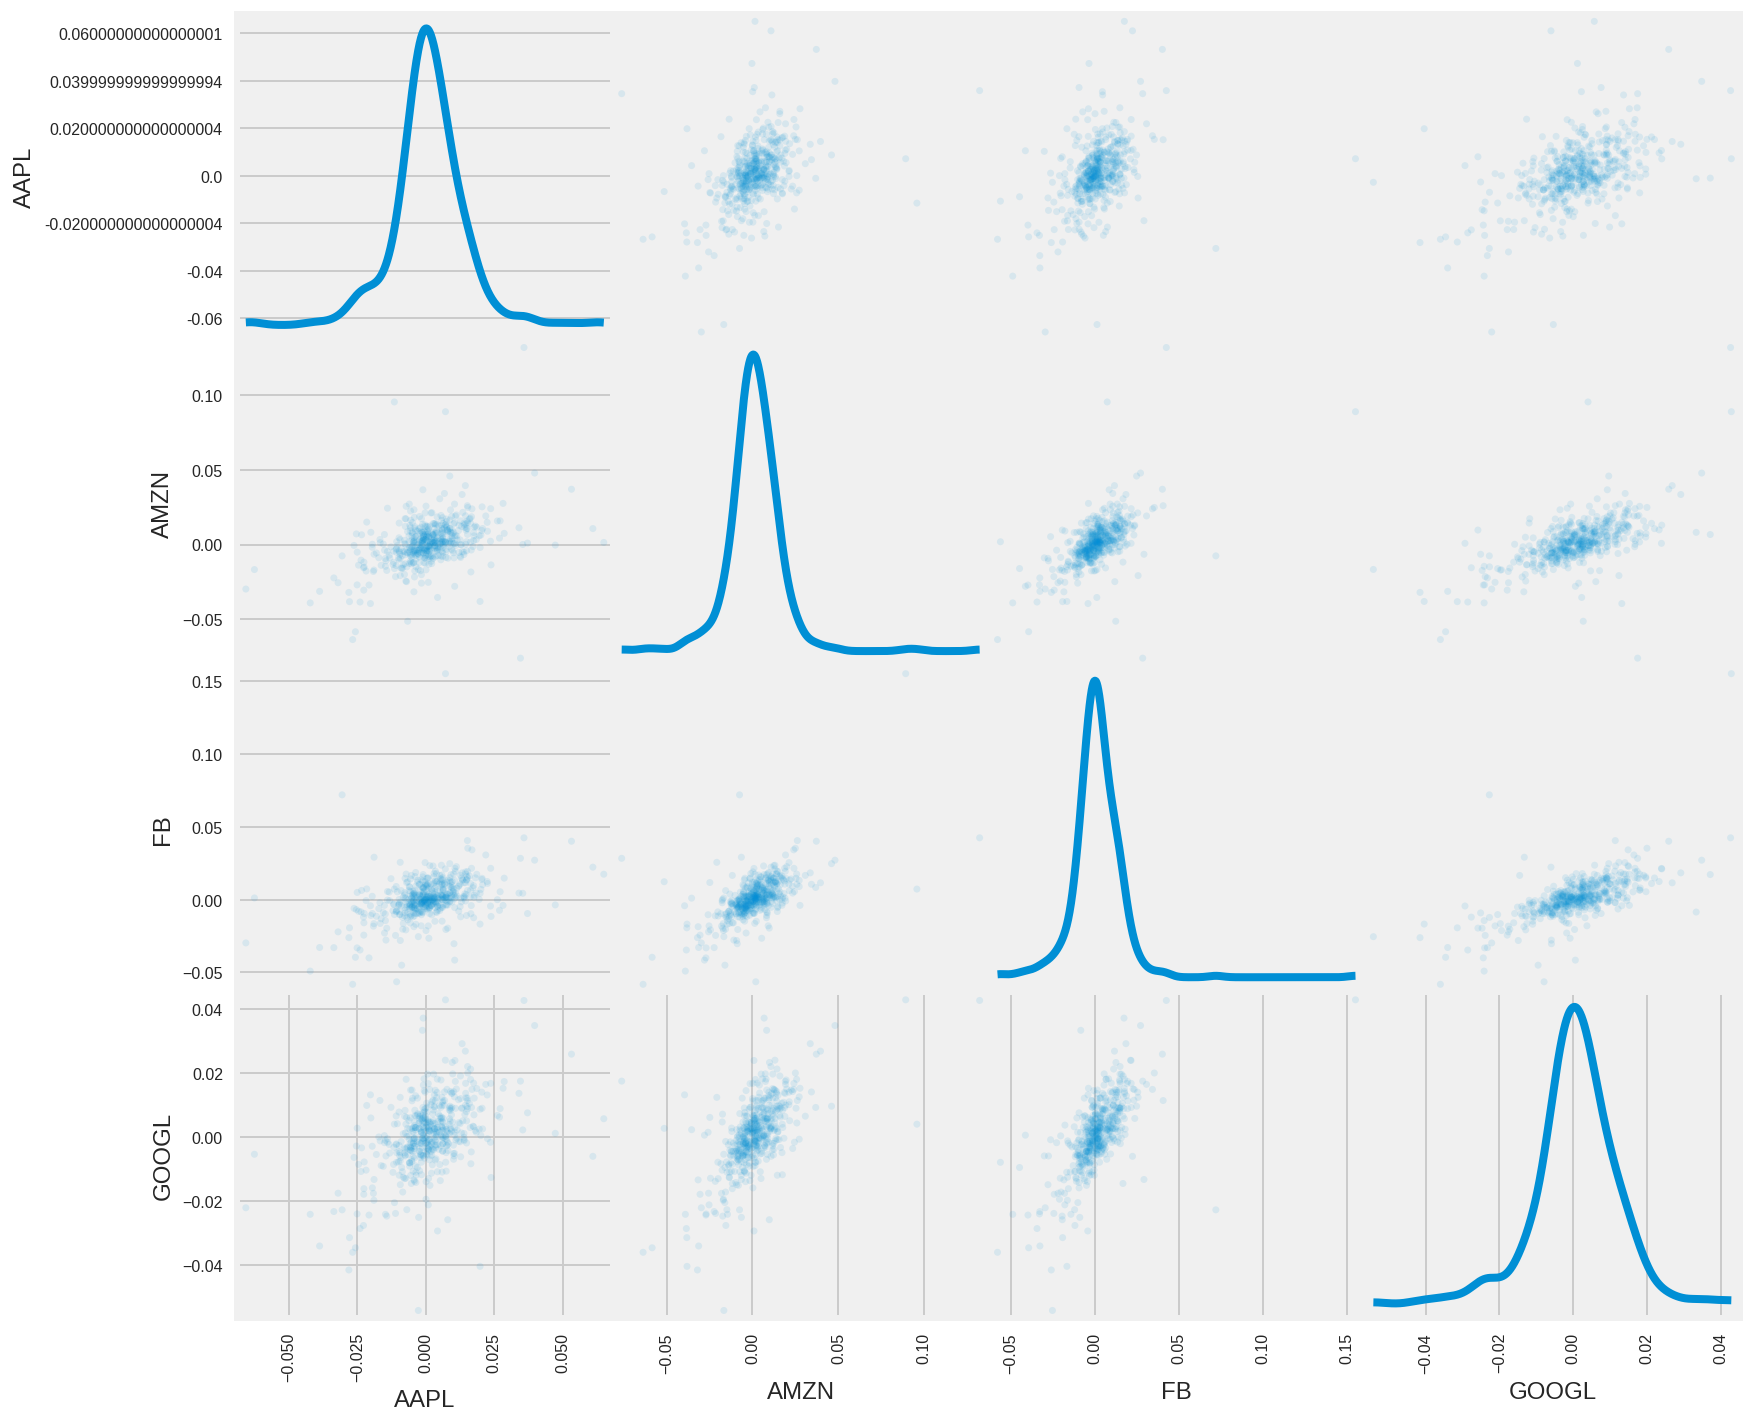

In [ ]:
returns.hist(bins=50, sharex=True, figsize=(12,8))
pd.scatter_matrix(returns, diagonal='kde', alpha=0.1,figsize=(12,12))

plt.show()

           AAPL      AMZN        FB     GOOGL
AAPL   1.000000  0.412631  0.409847  0.487958
AMZN   0.412631  1.000000  0.604482  0.617829
FB     0.409847  0.604482  1.000000  0.655233
GOOGL  0.487958  0.617829  0.655233  1.000000


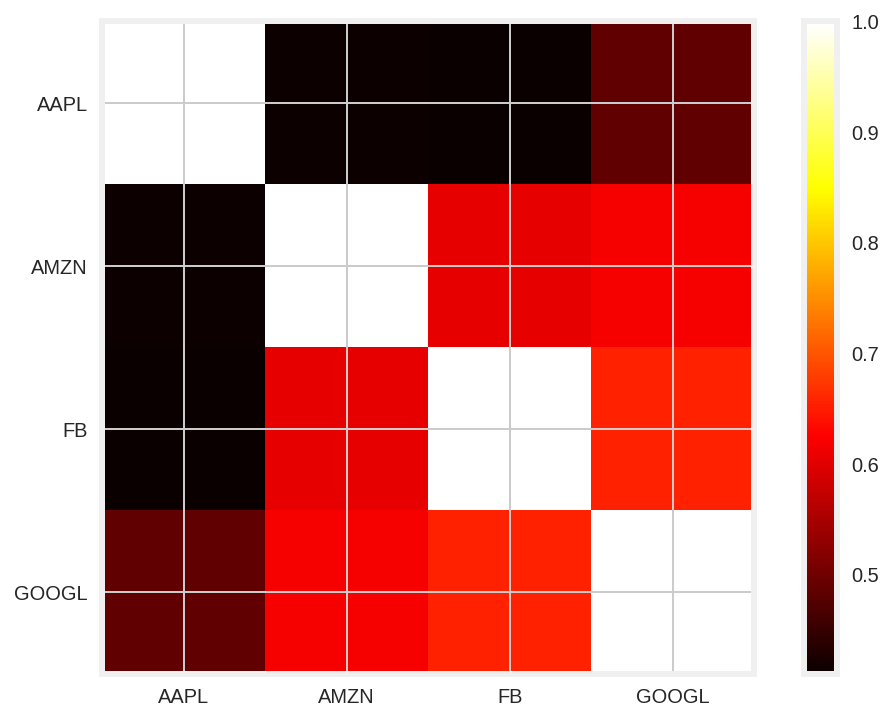

In [ ]:
corr = returns.corr()
print(corr)
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='hot',interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)),corr.columns)
plt.yticks(range(len(corr)),corr.columns)
plt.show()

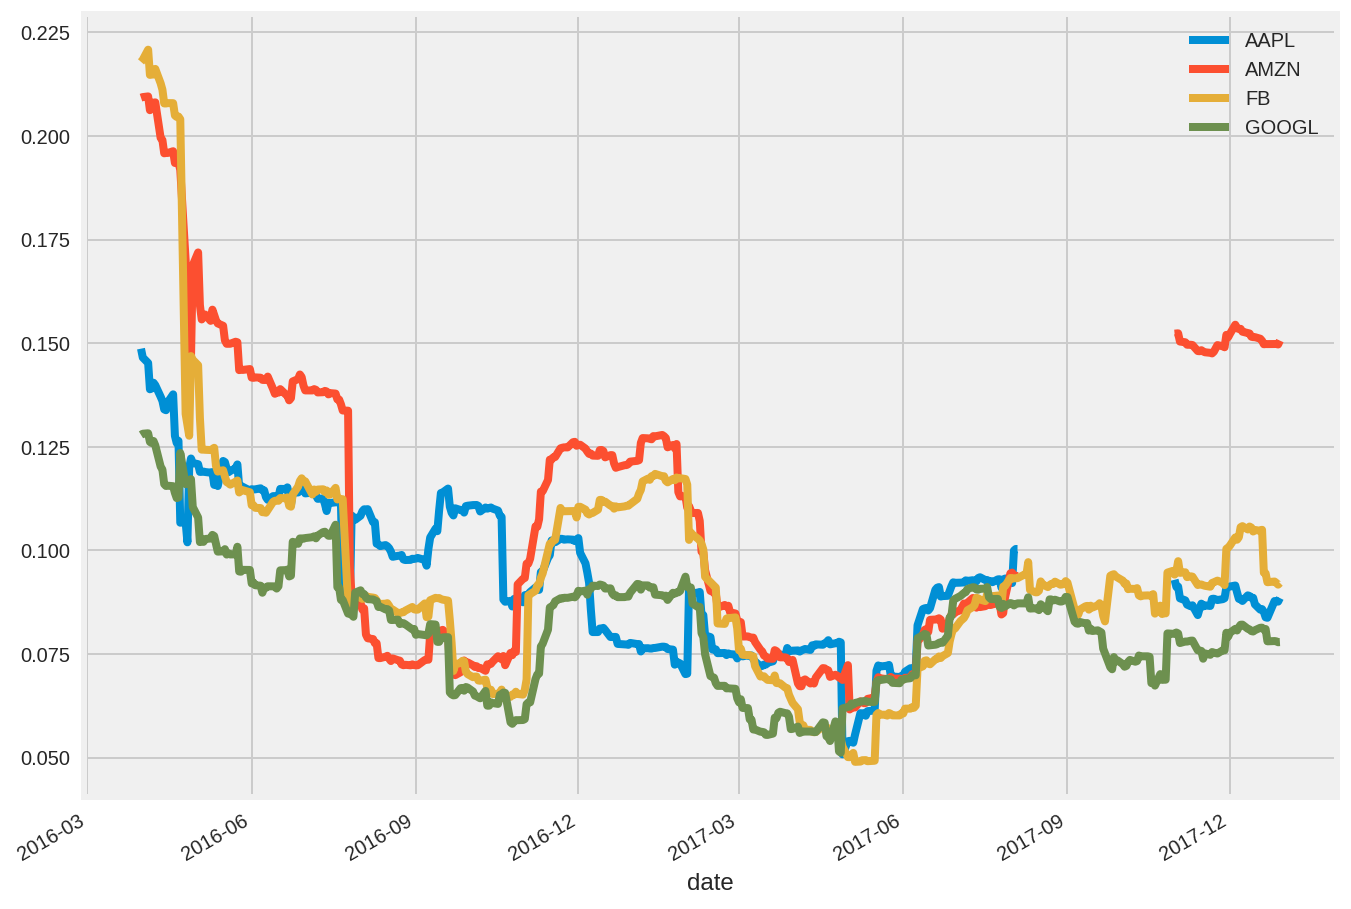

In [ ]:
# Calculate the volatility
min_periods = 60 
volatility = returns.rolling(min_periods).std() * np.sqrt(min_periods) 
# Plot the volatility
volatility.plot(figsize=(10, 8))

plt.show()